<a href="https://colab.research.google.com/github/AgarwalMayank2/Face_Detection/blob/main/applying_ML_algorithms/KNN_PRMLproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# KNN Model

In [2]:
import numpy as np
import math

In [3]:
def euclidean_dist(x,y):
  # x1,y1,z1=x
  # x2,y2,z2=y
  return math.sqrt(sum([(a-b)**2 for a,b in zip(x,y)]))

In [4]:
from collections import Counter

In [5]:
def knn(k, X_train, X_test, y_test):
  predictions=[]
  for i in range(X_test.shape[0]):
    distances=[]
    nearest_labels=[]
    for j in range(X_train.shape[0]):
      # append the pair (distance, index) to distances
      dist=euclidean_dist(X_test[i], X_train[j])
      distances.append((dist, j))
    # sorting distances on the basis of first item of pair i.e. distance
    distances.sort(key=lambda x:x[0])
    for k1 in range(min(k, len(distances))):  # Ensure k does not exceed available distances
      nearest_labels.append(y_train[distances[k1][1]])

    label_counts = Counter(nearest_labels)
    most_common_label = label_counts.most_common(1)[0][0] if nearest_labels else -1

    predictions.append(label_encoder.inverse_transform([most_common_label])[0])

    # if (i<=100 and i%10==0) or i==200:
    #   print(f'Label {i} detected : {predictions[i]}')

  accuracy = findAccuracy(predictions, y_test)
  return predictions, accuracy

In [33]:
def findAccuracy(predictions, y_test):
  count=0
  # print(predictions)
  # print(y_test)
  for i in range(len(predictions)):
    if predictions[i]==label_encoder.inverse_transform([y_test[i]])[0]:
      count+=1

  accuracy = count/len(predictions)
  return accuracy*100

# Reading and Filtering Filtered CNN features

In [7]:
url_filtered_CNN_features_dataset = 'https://raw.githubusercontent.com/AgarwalMayank2/Face_Detection/refs/heads/main/processed_dataset/filtered_CNN_features_dataset.csv' #for CNN limited
df = pd.read_csv(url_filtered_CNN_features_dataset) # reading url for extracted CNN_features_dataset_limited.csv
df.shape

(4324, 2050)

In [9]:
label_counts = df['2048'].value_counts()
valid_labels = label_counts[label_counts >= 80].index
filtered_df_cnn = df[df['2048'].isin(valid_labels)]
filtered_df_cnn = filtered_df_cnn.groupby('2048').apply(lambda x: x.sample(min(len(x), 105), random_state=42)).reset_index(drop=True)
    # limiting dataset to have max 105 images per person
filtered_df_cnn.drop('Unnamed: 0', axis=1, inplace=True)
filtered_df_cnn.head()
person_counts=filtered_df_cnn['2048'].value_counts()
print(person_counts)
print(filtered_df_cnn.shape)

2048
Colin_Powell         105
Donald_Rumsfeld      105
George_W_Bush        105
Gerhard_Schroeder    105
Tony_Blair           105
Name: count, dtype: int64
(525, 2049)


<ipython-input-9-f9366ac96588>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df_cnn = filtered_df_cnn.groupby('2048').apply(lambda x: x.sample(min(len(x), 105), random_state=42)).reset_index(drop=True)


## Train/Test split - for CNN dataset

In [10]:
# Separate features and labels
X_cnn = filtered_df_cnn.iloc[:, :-1]
y_cnn = filtered_df_cnn.iloc[:, -1]

# Encode labels (alphabetically)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_cnn)
# encoding is benificial as working on numbers is lot easier than working on string

# Ensure stratified split (16 training, 4 testing per class)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_encoded, test_size=1/5, random_state=42, stratify=y_encoded)

# Normalize features
scaler = StandardScaler()
X_train_cnn = scaler.fit_transform(X_train_cnn)
X_test_cnn = scaler.transform(X_test_cnn)

print(f"Dataset size: {filtered_df_cnn.shape}")
print(f"Training size: {X_train_cnn.shape}, Testing size: {X_test_cnn.shape}")

Dataset size: (525, 2049)
Training size: (420, 2048), Testing size: (105, 2048)


## Dimensionality reduction

In [11]:
from sklearn.decomposition import PCA

### Applying PCA on CNN features

In [12]:
pca=PCA(n_components=400)

X_train_cnn_pca=pca.fit_transform(X_train_cnn)
X_test_cnn_pca=pca.transform(X_test_cnn)

print(X_train_cnn_pca.shape)
print(X_test_cnn_pca.shape)

(420, 400)
(105, 400)


In [13]:
import numpy as np
print(np.sum(pca.explained_variance_ratio_))  # Should be close to 1

0.9988478889237746


### Applying LDA on CNN features

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA with at most (number of classes - 1) components
lda = LDA(n_components=min(500, len(set(y_train_cnn)) - 1))

X_train_cnn_lda = lda.fit_transform(X_train_cnn, y_train_cnn)
X_test_cnn_lda = lda.transform(X_test_cnn)

print(X_train_cnn_lda.shape)
print(X_test_cnn_lda.shape)

(420, 4)
(105, 4)


## Setting y_train and y_test

In [15]:
y_train = y_train_cnn
y_test = y_test_cnn

print(y_train[:10])
print(y_test[:10])

[4 2 4 1 3 1 2 2 1 3]
[1 1 2 1 1 3 2 1 3 0]


# Reading and Filtering Filtered LBP features

In [16]:
url_filtered_lbp_features = 'https://raw.githubusercontent.com/AgarwalMayank2/Face_Detection/refs/heads/main/processed_dataset/filtered_LBP_features_dataset.csv'
df = pd.read_csv(url_filtered_lbp_features)

In [17]:
label_counts = df['256'].value_counts()
valid_labels = label_counts[label_counts >= 80].index
filtered_df_LBP = df[df['256'].isin(valid_labels)]
filtered_df_LBP = filtered_df_LBP.groupby('256').apply(lambda x: x.sample(min(len(x), 105), random_state=42)).reset_index(drop=True)
    # limiting dataset to have max 105 images pre prson
filtered_df_LBP.drop('Unnamed: 0', axis=1, inplace=True)
person_counts = filtered_df_LBP['256'].value_counts()
print(filtered_df_LBP.head())
print(person_counts)
print(filtered_df_LBP.shape)

       0     1      2      3     4     5      6      7      8     9  ...  \
0  618.0  51.0  433.0  186.0  59.0  12.0  180.0  305.0  247.0  25.0  ...   
1  687.0  49.0  386.0  187.0  62.0   6.0  184.0  299.0  371.0  24.0  ...   
2  767.0  79.0  380.0  189.0  73.0   4.0  204.0  278.0  376.0  35.0  ...   
3  602.0  50.0  314.0  235.0  46.0   6.0  225.0  451.0  389.0  24.0  ...   
4  413.0  43.0  282.0  105.0  41.0  12.0   66.0  154.0  182.0  28.0  ...   

     247     248    249   250    251    252    253    254      255  \
0  325.0  1439.0  489.0  37.0  365.0  574.0  474.0  453.0  14110.0   
1  549.0  2319.0  662.0  40.0  550.0  586.0  474.0  443.0  14503.0   
2  429.0  2392.0  474.0  28.0  384.0  572.0  394.0  490.0  23504.0   
3  546.0  3026.0  863.0  55.0  766.0  721.0  497.0  564.0  11584.0   
4  306.0  2261.0  402.0  42.0  345.0  366.0  327.0  254.0  31421.0   

            256  
0  Colin_Powell  
1  Colin_Powell  
2  Colin_Powell  
3  Colin_Powell  
4  Colin_Powell  

[5 rows x 257

<ipython-input-17-663dd840bccb>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df_LBP = filtered_df_LBP.groupby('256').apply(lambda x: x.sample(min(len(x), 105), random_state=42)).reset_index(drop=True)


## Train/Test split - for LBP dataset

In [18]:
# Separate features and labels
X_LBP = filtered_df_LBP.iloc[:, :-1]
y_LBP = filtered_df_LBP.iloc[:, -1]

# Encode labels (alphabetically)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_LBP)
# encoding is benificial as working on numbers is lot easier than working on string

# Ensure stratified split (64 training, 16 testing per class)
X_train_LBP, X_test_LBP, y_train_LBP, y_test_LBP = train_test_split(X_LBP, y_encoded, test_size=1/5, random_state=42, stratify=y_encoded)

# Normalize features
scaler = StandardScaler()
X_train_LBP = scaler.fit_transform(X_train_LBP)
X_test_LBP = scaler.transform(X_test_LBP)

print(f"Dataset size: {filtered_df_LBP.shape}")
print(f"Training size: {X_train_LBP.shape}, Testing size: {X_test_LBP.shape}")

Dataset size: (525, 257)
Training size: (420, 256), Testing size: (105, 256)


## Dimensionality Reduction

### Applying PCA on LBP features

In [19]:
pca=PCA(n_components=150)

X_train_LBP_pca=pca.fit_transform(X_train_LBP)
X_test_LBP_pca=pca.transform(X_test_LBP)

print(X_train_LBP_pca.shape)
print(X_test_LBP_pca.shape)

(420, 150)
(105, 150)


In [20]:
import numpy as np
print(np.sum(pca.explained_variance_ratio_))  # Should be close to 1

0.9709552698602606


### Applying LDA on LBP features

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA with at most (number of classes - 1) components
lda = LDA(n_components=min(500, len(set(y_train_LBP)) - 1))

X_train_LBP_lda = lda.fit_transform(X_train_LBP, y_train_LBP)
X_test_LBP_lda = lda.transform(X_test_LBP)

print(X_train_LBP_lda.shape)
print(X_test_LBP_lda.shape)

(420, 4)
(105, 4)


## Setting y_train and y_test

In [22]:
y_train = y_train_LBP
y_test = y_test_LBP

print(y_train[:10])
print(y_test[:10])

[4 2 4 1 3 1 2 2 1 3]
[1 1 2 1 1 3 2 1 3 0]


# Calling KNN function on CNN and LBP features (without Dimensionality Reduction)

In [ ]:
y_pred, acc = knn(5, X_train_cnn, X_test_cnn, y_test)
print("Predictions : ", y_pred)
print("Test Accuracy : ", acc, " %")
y_pred, acc = knn(5, X_train_cnn, X_train_cnn, y_train)
print("Predictions : ", y_pred)
print("Train Accuracy : ", acc, " %")

Test Accuracy :  57.14285714285714  %
Train Accuracy :  80.0  %


In [ ]:
y_pred, acc = knn(5, X_train_LBP, X_test_LBP, y_test)
print("Predictions : ", y_pred)
print("Test Accuracy : ", acc, " %")
y_pred, acc = knn(5, X_train_LBP, X_train_LBP, y_train)
print("Predictions : ", y_pred)
print("Train Accuracy : ", acc, " %")

Predictions :  ['Donald_Rumsfeld', 'Tony_Blair', 'George_W_Bush', 'Donald_Rumsfeld', 'Colin_Powell', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Colin_Powell', 'Colin_Powell', 'Colin_Powell', 'Tony_Blair', 'George_W_Bush', 'Donald_Rumsfeld', 'Colin_Powell', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'George_W_Bush', 'Gerhard_Schroeder', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Tony_Blair', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Tony_Blair', 'Colin_Powell', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Tony_Blair', 'Gerhard_Schroeder', 'George_W_Bush', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'George_W_Bush', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerha

# Calling KNN function on CNN and LBP features (with Dimensionality Reduction)

## PCA on CNN and LBP features

In [ ]:
y_pred, acc = knn(5, X_train_cnn_pca, X_test_cnn_pca, y_test)
print("Predictions : ", y_pred)
print("Test Accuracy : ", acc, " %")
y_pred, acc = knn(5, X_train_cnn_pca, X_train_cnn_pca, y_train)
print("Train Accuracy : ", acc, " %")

Predictions :  ['Donald_Rumsfeld', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Colin_Powell', 'Colin_Powell', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Colin_Powell', 'Colin_Powell', 'George_W_Bush', 'Donald_Rumsfeld', 'Tony_Blair', 'Colin_Powell', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerhard_Schroeder', 'Colin_Powell', 'Colin_Powell', 'Colin_Powell', 'Donald_Rumsfeld', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Tony_Blair', 'Donald_Rumsfeld', 'Tony_Blair', 'Tony_Blair', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Tony_Blair', 'George_W_Bush', 'Donald_Rumsfeld', 'Tony_Blair', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Colin_Powell', 'Gerhard_Schroeder', 'Gerhard_Sc

In [ ]:
y_pred, acc = knn(5, X_train_LBP_pca, X_test_LBP_pca, y_test)
print("Predictions : ", y_pred)
print("Test Accuracy : ", acc, " %")
y_pred, acc = knn(5, X_train_LBP_pca, X_train_LBP_pca, y_train)
print("Predictions : ", y_pred)
print("Train Accuracy : ", acc, " %")

Predictions :  ['Donald_Rumsfeld', 'Tony_Blair', 'George_W_Bush', 'Donald_Rumsfeld', 'Colin_Powell', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Colin_Powell', 'Colin_Powell', 'Colin_Powell', 'Tony_Blair', 'George_W_Bush', 'Donald_Rumsfeld', 'Colin_Powell', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Tony_Blair', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Donald_Rumsfel

## LDA on CNN and LBP features

In [ ]:
y_pred, acc = knn(5, X_train_cnn_lda, X_test_cnn_lda, y_test)
print("Predictions : ", y_pred)
print("Test Accuracy : ", acc, " %")
y_pred, acc = knn(5, X_train_cnn_lda, X_train_cnn_lda, y_train)
print("Predictions : ", y_pred)
print("Train Accuracy : ", acc, " %")

Predictions :  ['Donald_Rumsfeld', 'Donald_Rumsfeld', 'George_W_Bush', 'Colin_Powell', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'George_W_Bush', 'Donald_Rumsfeld', 'Tony_Blair', 'Colin_Powell', 'Tony_Blair', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Colin_Powell', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Colin_Powell', 'Colin_Powell', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Tony_Blair', 'Donald_Rumsfeld', 'Tony_Blair', 'Tony_Blair', 'Colin_Powell', 'Donald_Rumsfeld', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Donald_Rumsfeld', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Gerhard_Schr

In [ ]:
y_pred, acc = knn(5, X_train_LBP_lda, X_test_LBP_lda, y_test)
print("Predictions : ", y_pred)
print("Test Accuracy : ", acc, " %")
y_pred, acc = knn(5, X_train_LBP_lda, X_train_LBP_lda, y_train)
print("Predictions : ", y_pred)
print("Train Accuracy : ", acc, " %")

Predictions :  ['Donald_Rumsfeld', 'Tony_Blair', 'Colin_Powell', 'Tony_Blair', 'Colin_Powell', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Colin_Powell', 'Donald_Rumsfeld', 'Colin_Powell', 'Tony_Blair', 'Colin_Powell', 'Tony_Blair', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Colin_Powell', 'Tony_Blair', 'Gerhard_Schroeder', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Colin_Powell', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'George_W_Bush', 'Tony_Blair', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Colin_Powell', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Donald_Rumsfeld', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Donald_Rumsfeld', 'Tony_Bla

# Combining CNN and LBP features (Concatenating)

In [23]:
combined_X_train = np.concatenate((X_train_cnn, X_train_LBP), axis=1)
combined_X_test = np.concatenate((X_test_cnn, X_test_LBP), axis=1)

In [24]:
print("No. of CNN features + No. of LBP features = ", X_train_cnn.shape[1] + X_train_LBP.shape[1])
print("Total no. of features after concatenation = ", combined_X_train.shape[1])

No. of CNN features + No. of LBP features =  2304
Total no. of features after concatenation =  2304


In [25]:
print(combined_X_train.shape[1])
print(combined_X_test.shape[1])

2304
2304


## Applying PCA on Combined features

In [26]:
pca=PCA(n_components=400)

X_train_pca=pca.fit_transform(combined_X_train)
X_test_pca=pca.transform(combined_X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

(420, 400)
(105, 400)


## Applying LDA on Combined features

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA with at most (number of classes - 1) components
lda = LDA(n_components=min(500, len(set(y_train)) - 1))

X_train_lda = lda.fit_transform(combined_X_train, y_train)
X_test_lda = lda.transform(combined_X_test)

print(X_train_lda.shape)
print(X_test_lda.shape)

(420, 4)
(105, 4)


# Importing libraries for visualisation

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [29]:
# Actual labels
y_test_labels = label_encoder.inverse_transform(y_test)

In [30]:
print(np.unique(y_test_labels))

['Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush' 'Gerhard_Schroeder'
 'Tony_Blair']


# Calling KNN function on Combined features (without Dimensionality Reduction)

### k vs Test and Train accuracy graph for Combined features without Dimensionality Reduction

In [32]:
test_accuracies=[]
train_accuracies=[]
for k in range(1,10):
  y_pred_test, acc_test = knn(k, combined_X_train, combined_X_test, y_test)
  test_accuracies.append((k,acc_test))
  y_pred_train, acc_train = knn(k, combined_X_train, combined_X_train, y_train)
  train_accuracies.append((k,acc_train))

print("Test accuracies = ", test_accuracies)
print("Train accuracies = ", train_accuracies)

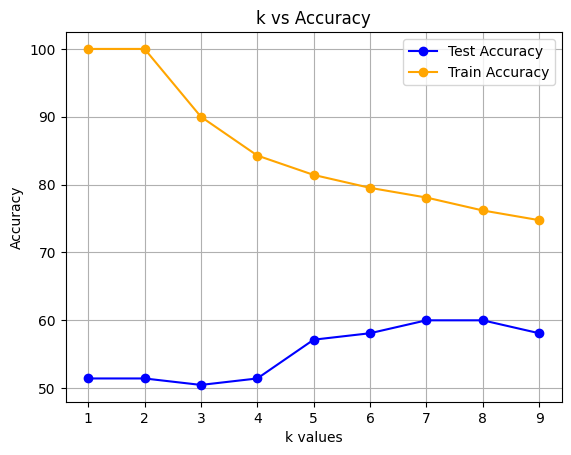

In [ ]:
# plot k vs test accuracy and train accuracy graph
import matplotlib.pyplot as plt

x_axis=[pair[0] for pair in test_accuracies]
y_axis_test=[pair[1] for pair in test_accuracies]
y_axis_train=[pair[1] for pair in train_accuracies]

plt.plot(x_axis, y_axis_test, marker='o', color='blue', label='Test Accuracy') # Test accuracy
plt.plot(x_axis, y_axis_train, marker='o', color='orange', label='Train Accuracy') # Train accuracy
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.legend()
plt.grid('True')
plt.show()

In [ ]:
best_k, best_acc = max(test_accuracies, key=lambda x: x[1])
print("Best k = ", best_k)
print("Best accuracy = ", best_acc, " %")

Best k =  6
Best accuracy =  63.8095238095238  %


In [ ]:
y_pred_test, acc_test = knn(best_k, combined_X_train, combined_X_test, y_test)
print("Predictions : ", y_pred_test)
print("Test Accuracy : ", acc_test, " %")
y_pred_train, acc_train = knn(best_k, combined_X_train, combined_X_train, y_train)
print("Predictions : ", y_pred_train)
print("Train Accuracy : ", acc_train, " %")

Predictions :  ['Donald_Rumsfeld', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Colin_Powell', 'Colin_Powell', 'Tony_Blair', 'Tony_Blair', 'Colin_Powell', 'Tony_Blair', 'George_W_Bush', 'George_W_Bush', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Colin_Powell', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerhard_Schroeder', 'Colin_Powell', 'Donald_Rumsfeld', 'Colin_Powell', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Tony_Blair', 'George_W_Bush', 'George_W_Bush', 'Tony_Blair', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Colin_Powell', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Geor

### Confusion Matrix (Combined Features without Dimensionality Reduction)

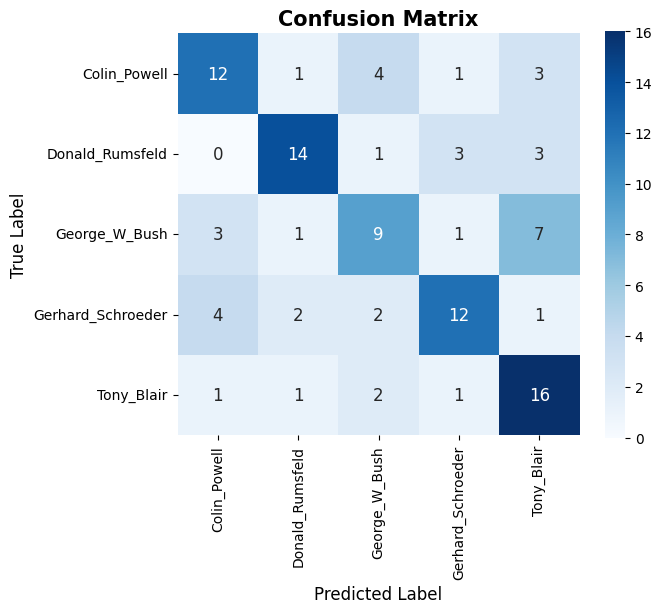

In [ ]:
# Inputs
y_true = np.array(y_test_labels)
y_pred = np.array(y_pred_test)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names
classes = np.unique(y_true)
class_names = [f"{c}" for c in classes]  # or actual names if you have them

# Plot the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            square=True, annot_kws={"size": 12})

plt.title("Confusion Matrix", fontsize=15, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Calling KNN function on Combined features (with Dimensionality Reduction)

## PCA on Combined features

### k vs Test and Train accuracy graph for PCA on Combined features

In [ ]:
test_accuracies=[]
train_accuracies=[]
for k in range(1,10):
  y_pred_test, acc_test = knn(k, X_train_pca, X_test_pca, y_test)
  test_accuracies.append((k,acc_test))
  y_pred_train, acc_train = knn(k, X_train_pca, X_train_pca, y_train)
  train_accuracies.append((k,acc_train))

print("Test accuracies = ", test_accuracies)
print("Train accuracies = ", train_accuracies)

Test accuracies =  [(1, 51.42857142857142), (2, 51.42857142857142), (3, 49.523809523809526), (4, 51.42857142857142), (5, 58.0952380952381), (6, 57.14285714285714), (7, 60.0), (8, 60.0), (9, 57.14285714285714)]
Train accuracies =  [(1, 100.0), (2, 100.0), (3, 90.0), (4, 84.76190476190476), (5, 80.71428571428572), (6, 79.76190476190477), (7, 78.33333333333333), (8, 76.19047619047619), (9, 75.47619047619048)]


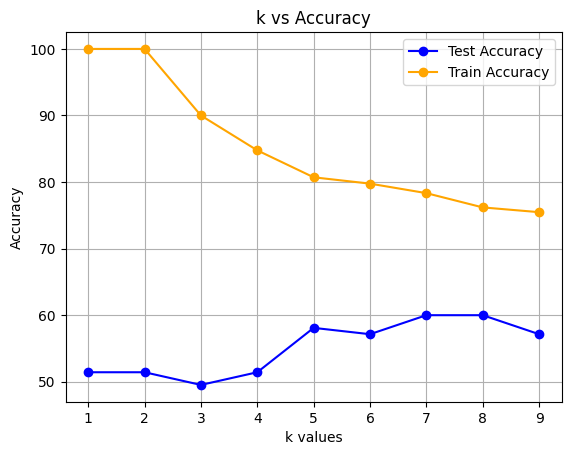

In [ ]:
# plot k vs test accuracy and train accuracy graph
import matplotlib.pyplot as plt

x_axis=[pair[0] for pair in test_accuracies]
y_axis_test=[pair[1] for pair in test_accuracies]
y_axis_train=[pair[1] for pair in train_accuracies]

plt.plot(x_axis, y_axis_test, marker='o', color='blue', label='Test Accuracy') # Test accuracy
plt.plot(x_axis, y_axis_train, marker='o', color='orange', label='Train Accuracy') # Train accuracy
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.legend()
plt.grid('True')
plt.show()

In [ ]:
best_k, best_acc = max(test_accuracies, key=lambda x: x[1])
print("Best k = ", best_k)
print("Best accuracy = ", best_acc)

Best k =  7
Best accuracy =  60.0


In [ ]:
y_pred_test, acc_test = knn(best_k, X_train_pca, X_test_pca, y_test)
print("Predictions : ", y_pred_test)
print("Test Accuracy : ", acc_test, " %")
y_pred_train, acc_train = knn(best_k, X_train_pca, X_train_pca, y_train)
print("Predictions : ", y_pred_train)
print("Train Accuracy : ", acc_train, " %")

Predictions :  ['Donald_Rumsfeld', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Colin_Powell', 'Colin_Powell', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'George_W_Bush', 'George_W_Bush', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Colin_Powell', 'George_W_Bush', 'George_W_Bush', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerhard_Schroeder', 'Colin_Powell', 'Donald_Rumsfeld', 'Colin_Powell', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Tony_Blair', 'George_W_Bush', 'George_W_Bush', 'Tony_Blair', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Tony_Blair', 'Tony_Blair', 'Tony_Blair', 'Colin_Powell', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'George

### Confusion Matrix (PCA on Combined Features)

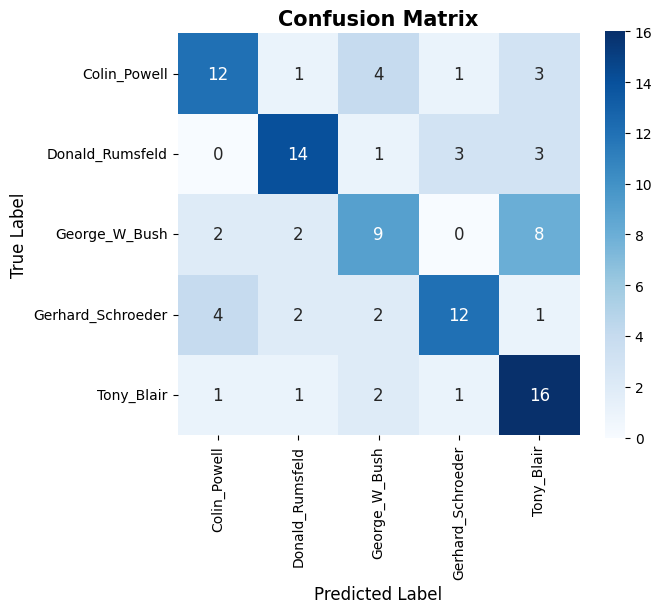

In [ ]:
# Inputs
y_true = np.array(y_test_labels)
y_pred = np.array(y_pred_test)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names
classes = np.unique(y_true)
class_names = [f"{c}" for c in classes]  # or actual names if you have them

# Plot the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            square=True, annot_kws={"size": 12})

plt.title("Confusion Matrix", fontsize=15, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## LDA on Combined features

### k vs Test and Train accuracy graph for LDA on Combined features

In [ ]:
test_accuracies=[]
train_accuracies=[]
for k in range(1,10):
  y_pred_test, acc_test = knn(k, X_train_lda, X_test_lda, y_test)
  test_accuracies.append((k,acc_test))
  y_pred_train, acc_train = knn(k, X_train_lda, X_train_lda, y_train)
  train_accuracies.append((k,acc_train))

print("Test accuracies = ", test_accuracies)
print("Train accuracies = ", train_accuracies)

Test accuracies =  [(1, 71.42857142857143), (2, 71.42857142857143), (3, 79.04761904761905), (4, 74.28571428571429), (5, 77.14285714285715), (6, 76.19047619047619), (7, 77.14285714285715), (8, 78.0952380952381), (9, 78.0952380952381)]
Train accuracies =  [(1, 100.0), (2, 100.0), (3, 98.09523809523809), (4, 98.09523809523809), (5, 97.85714285714285), (6, 97.85714285714285), (7, 97.14285714285714), (8, 96.9047619047619), (9, 96.66666666666667)]


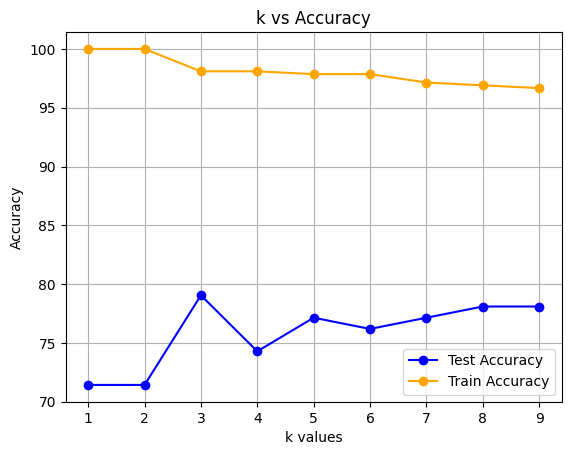

In [ ]:
# plot k vs test accuracy and train accuracy graph
import matplotlib.pyplot as plt

x_axis=[pair[0] for pair in test_accuracies]
y_axis_test=[pair[1] for pair in test_accuracies]
y_axis_train=[pair[1] for pair in train_accuracies]

plt.plot(x_axis, y_axis_test, marker='o', color='blue', label='Test Accuracy') # Test accuracy
plt.plot(x_axis, y_axis_train, marker='o', color='orange', label='Train Accuracy') # Train accuracy
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.legend()
plt.grid('True')
plt.show()

In [ ]:
best_k, best_acc = max(test_accuracies, key=lambda x: x[1])
print("Best k = ", best_k)
print("Best accuracy = ", best_acc)

Best k =  3
Best accuracy =  79.04761904761905


In [ ]:
y_pred_test, acc_test = knn(best_k, X_train_lda, X_test_lda, y_test)
print("Predictions : ", y_pred_test)
print("Test Accuracy : ", acc_test, " %")
y_pred_train, acc_train = knn(best_k, X_train_lda, X_train_lda, y_train)
print("Predictions : ", y_pred_train)
print("Train Accuracy : ", acc_train, " %")

Predictions :  ['Donald_Rumsfeld', 'Donald_Rumsfeld', 'George_W_Bush', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'George_W_Bush', 'Donald_Rumsfeld', 'Tony_Blair', 'Colin_Powell', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Colin_Powell', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Colin_Powell', 'Colin_Powell', 'Tony_Blair', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'George_W_Bush', 'Colin_Powell', 'George_W_Bush', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Donald_Rumsfeld', 'Tony_Blair', 'Tony_Blair', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Tony_Blair', 'Tony_Blair', 'Donald_Rumsfeld', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Colin_Powell', 'Gerhard_Schroeder', 'Gerhard_Schroe

### Confusion Matrix (LDA on Combined Features)

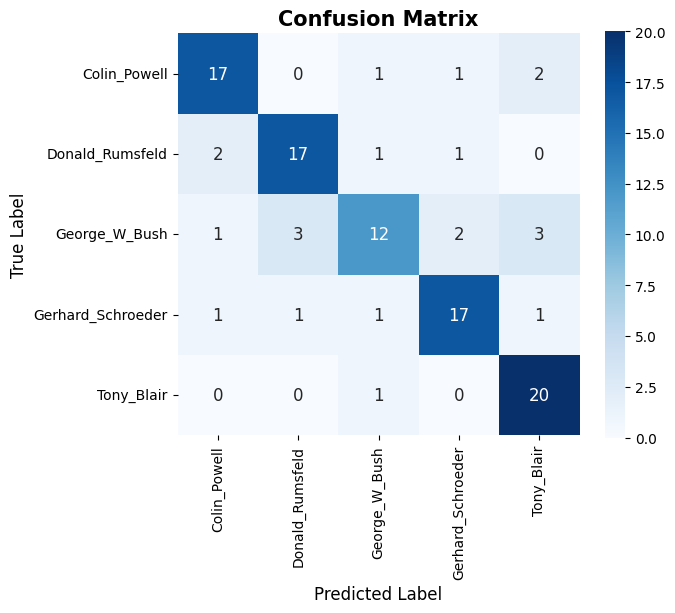

In [ ]:
# Inputs
y_true = np.array(y_test_labels)
y_pred = np.array(y_pred_test)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names
classes = np.unique(y_true)
class_names = [f"{c}" for c in classes]  # or actual names if you have them

# Plot the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            square=True, annot_kws={"size": 12})

plt.title("Confusion Matrix", fontsize=15, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Visualization

## Apply LDA on Combined features to keep only 2 features

In [ ]:
lda = LDA(n_components=2)

X_train_lda_graph = lda.fit_transform(combined_X_train, y_train)
X_test_lda_graph = lda.transform(combined_X_test)

print(X_train_lda_graph.shape)
print(X_test_lda_graph.shape)

(420, 2)
(105, 2)


## k vs Test and Train accuracy graph for LDA (final features = 2) on Combined features

In [ ]:
test_accuracies=[]
train_accuracies=[]
for k in range(1,10):
  y_pred_test, acc_test = knn(k, X_train_lda_graph, X_test_lda_graph, y_test)
  test_accuracies.append((k,acc_test))
  y_pred_train, acc_train = knn(k, X_train_lda_graph, X_train_lda_graph, y_train)
  train_accuracies.append((k,acc_train))

print("Test accuracies = ", test_accuracies)
print("Train accuracies = ", train_accuracies)

Test accuracies =  [(1, 59.04761904761905), (2, 59.04761904761905), (3, 60.0), (4, 60.952380952380956), (5, 59.04761904761905), (6, 63.8095238095238), (7, 60.0), (8, 60.952380952380956), (9, 60.952380952380956)]
Train accuracies =  [(1, 100.0), (2, 100.0), (3, 86.66666666666667), (4, 89.04761904761904), (5, 82.38095238095238), (6, 83.57142857142857), (7, 80.47619047619048), (8, 82.14285714285714), (9, 80.95238095238095)]


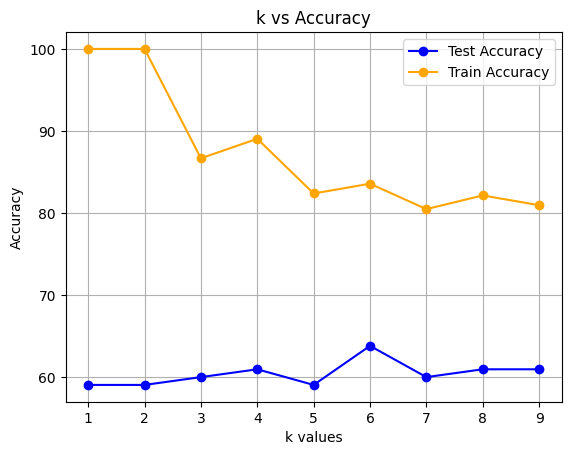

In [ ]:
# plot k vs test accuracy and train accuracy graph
import matplotlib.pyplot as plt

x_axis=[pair[0] for pair in test_accuracies]
y_axis_test=[pair[1] for pair in test_accuracies]
y_axis_train=[pair[1] for pair in train_accuracies]

plt.plot(x_axis, y_axis_test, marker='o', color='blue', label='Test Accuracy') # Test accuracy
plt.plot(x_axis, y_axis_train, marker='o', color='orange', label='Train Accuracy') # Train accuracy
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy')
plt.legend()
plt.grid('True')
plt.show()

In [ ]:
best_k, best_acc = max(test_accuracies, key=lambda x: x[1])
print("Best k = ", best_k)
print("Best accuracy = ", best_acc)

Best k =  6
Best accuracy =  63.8095238095238


In [ ]:
y_pred_test, acc_test = knn(best_k, X_train_lda_graph, X_test_lda_graph, y_test)
print("Predictions : ", y_pred_test)
print("Test Accuracy : ", acc_test, " %")
y_pred_train, acc_train = knn(best_k, X_train_lda_graph, X_train_lda_graph, y_train)
print("Predictions : ", y_pred_train)
print("Train Accuracy : ", acc_train, " %")

Predictions :  ['Donald_Rumsfeld', 'Donald_Rumsfeld', 'George_W_Bush', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'George_W_Bush', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Colin_Powell', 'George_W_Bush', 'Tony_Blair', 'Colin_Powell', 'Tony_Blair', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'George_W_Bush', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Gerhard_Schroeder', 'Colin_Powell', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Colin_Powell', 'Gerhard_Schroeder', 'George_W_Bush', 'George_W_Bush', 'Tony_Blair', 'Donald_Rumsfeld', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'George_W_Bush', 'Tony_Blair', 'Tony_Blair', 'Gerhard_Schroeder', 'Tony_Blair', 'Donald_Rumsfeld', 'Colin_Powell', 'Tony_Blair', 'George_W_Bush', 'Tony_Blair', 'Gerhard_Schroeder', 'Gerh

## Confusion Matrix (LDA on Combined Features)

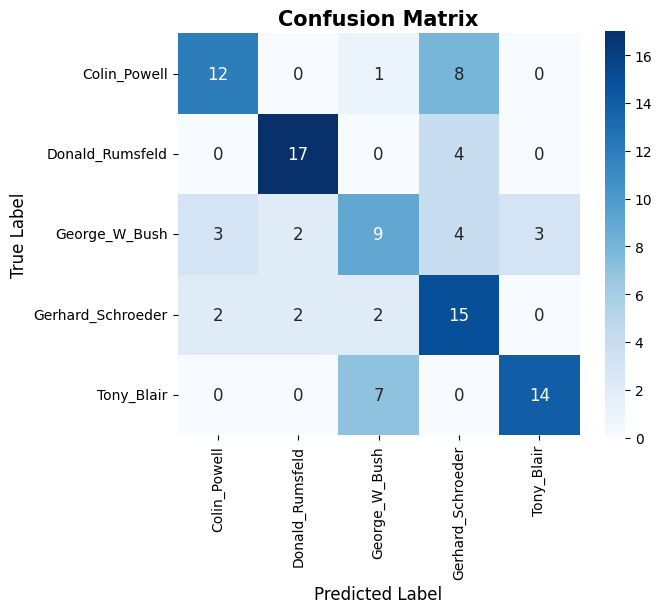

In [ ]:
# Inputs
y_true = np.array(y_test_labels)
y_pred = np.array(y_pred_test)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names
classes = np.unique(y_true)
class_names = [f"{c}" for c in classes]  # or actual names if you have them

# Plot the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            square=True, annot_kws={"size": 12})

plt.title("Confusion Matrix", fontsize=15, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Graph visualisation

<ipython-input-96-f2875c8e1dee>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))


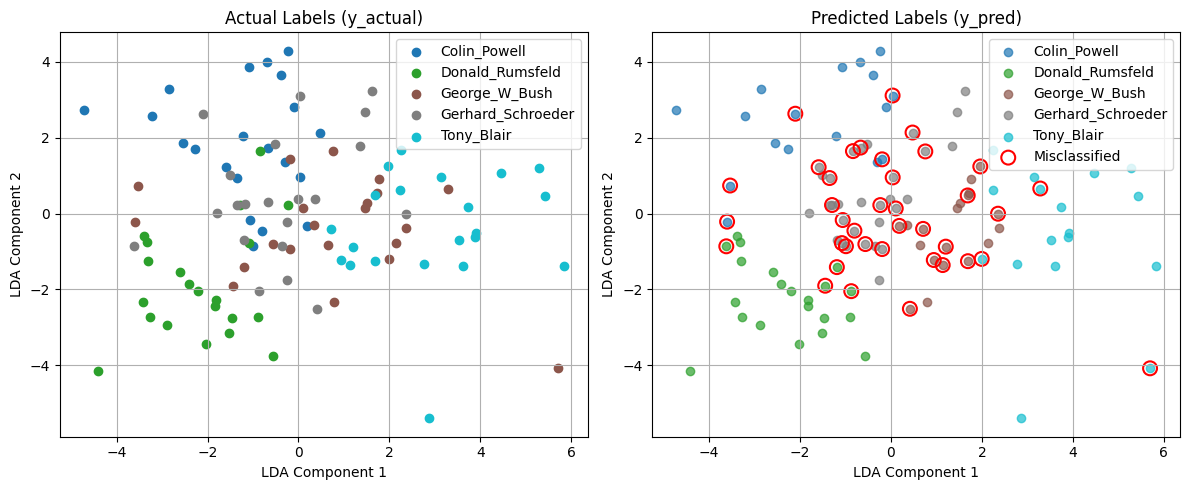

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_plot = X_test_lda_graph
y_actual = np.array(y_test_labels)
y_pred = np.array(y_pred_test)

classes = np.unique(y_actual)
colors = plt.cm.get_cmap('tab10', len(classes))

# Identify misclassified points
misclassified = y_actual != y_pred

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot y_actual ---
for i, label in enumerate(classes):
    indices = np.where(y_actual == label)
    axs[0].scatter(X_plot[indices, 0], X_plot[indices, 1], label=f'{label}', color=colors(i))
axs[0].set_title("Actual Labels (y_actual)")
axs[0].set_xlabel("LDA Component 1")
axs[0].set_ylabel("LDA Component 2")
axs[0].legend()
axs[0].grid(True)

# --- Plot y_pred ---
for i, label in enumerate(classes):
    indices = np.where(y_pred == label)
    axs[1].scatter(X_plot[indices, 0], X_plot[indices, 1], label=f'{label}', color=colors(i), alpha=0.7)

# Highlight misclassified points with red borders
axs[1].scatter(X_plot[misclassified, 0], X_plot[misclassified, 1],
               facecolors='none', edgecolors='red', s=100, linewidths=1.5, label='Misclassified')

axs[1].set_title("Predicted Labels (y_pred)")
axs[1].set_xlabel("LDA Component 1")
axs[1].set_ylabel("LDA Component 2")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
